<a href="https://colab.research.google.com/github/SHIN-sped/SHIN-sped/blob/master/Titanic_%EA%B0%95%EC%9D%98_%EB%B2%84%EC%A0%84_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Titanic 입문 (머신러닝 입문)

타이타닉 EDA to Prediction

* 타이타닉 챌린지는 나이, 성별 또는 승객 클래스와 같은 변수를 기반으로 주어진 승객의 생존 또는 사망을 예측하는 경쟁입니다.
* 앞에서 사이킷런을 공부하기 위해 같은 샘플을 해보았습니다.
* 사이킷 런 기반으로 분석을 해보겠습니다.



사이킷런 (sklearn이라고도 부름) 은 무료 소프트웨어로 파이썬 프로그래밍 언어를 위한 머신러닝 라이브러리이다.
Classification, Regression, Clustering, Descision Tree 등의 다양한 알고리즘을 적용할 수 있는 함수들을 제공하며 현재도 수 많은 알고리즘이 추가적으로 제공되고 있습니다.
사이킷런 자체 샘플 데이터도 있고, UC Irvine 에서 제공하는 데이터도 있습니다. 우리는 캐글대회의 기본인 타이타닉으로 작업을 하며 이해를 하겠습니다.

# Part1: Exploratory Data Analysis(EDA)

## Task 1 - 시작하기

* 자료 다운로드하기
[자료 다운로드](https://www.kaggle.com/c/3136/download-all)

으로 가서 파일을 다운로드 한다. (Kaggle note에서 할 때는 불러 오는 것이 좀 더 단순하나 주피터 노트북에서 할 때는 다운로드 및 임포트를 해야한다.)

* 필요한 것들을 임포트 좀 해야겠죠.



In [ ]:
import math, time, random, datetime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
import xgboost as xgb
import seaborn as sns
plt.style.use('seaborn-whitegrid')

%matplotlib inline

import missingno

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')


from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## Task 2 - 파일보기

* 파일을 보겠습니다.

* Kaggle에서는 우측의 Data에 가셔서 input 에서 원하는 파일을 보세요

* 다운로드한 파일을 업로드하여 임포트 합니다.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


* 이어서 이를 데이터프레임에 임포트하여 데이터셋이 판다스 데이터프레임에 임포트 되도록 합니다.

In [ ]:
import io
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
gender_submission = pd.read_csv(io.BytesIO(uploaded['gender_submission.csv']))

PI = test['PassengerId']  # 따로 잘 떼어 놓습니다.

우리가 기계를 훈련시킬 트레인 파일을 한 번 보도록 하겠습니다.

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* 우리가 나중에 최종 시험 볼 대상인 test 파일을 보겠습니다.

In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


* 마지막으로 우리가 제출할 포맷이 될 gender submission 파일을 보겠습니다.

In [ ]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


* 보시다시피 Passenger id 는 단지 누구가 누구이다 라는 것을 밝히는 identifier인 것 같고
* Survived 는 0이면 사망이고 1이면 살아 남은 사람인 것 같습니다.
* 그럼 일단 훈련시킬 train 파일에 집중하도록 하겠습니다.
* 파일의 길이를 보지요

In [ ]:
len(train)

891

* 891명에 대한 데이터 입니다.

#### Iniital (Wild) Guess
 
* 항목을 보면 PClass 는 객실의 레벨인 것 같습니다. 1이 제일 좋은 곳이고 3이 제일 낮은 곳인 것 같습니다.
* 이름은 별 의미가 없을 수도 있으나 중간에 Mr. Miss, Mrs 등이 아닌 master, rev, capt 등이 나오는데 이는 의미가 있습니다.
* Sex는 중요합니다. 보나마나 여성과 아이들을 우선적으로 구명 보트에 타게 했을 것이므로 남성이면 사망 확률이 훨씬 높지요
* Age도 중요합니다. 어릴 수록 구명 보트에 탔을 가능성이 크니까요
* SibSp는 배우자나 형제들과 같이 탄 즉, 가족의 숫자를 나타내므로 가족이 있는 사람의 생존 확률은 컸을 것이라 사료 됩니다.
* Parch 는 부모, 아이들이 같이 탄 경우니까, 역시 생존 확률이 좀 더 높을 것이라 생각됩니다.
* Ticket은 어떻게 의미를 두어야 할지 아직 파악이 안 됩니다. Fare나 Cabin과 연관이 있을 것입니다.
* Fare는 비쌀 수록 생존 확률이 높을 가능성이 클 것으로 생각됩니다.
* Cabin도 정해진 캐빈에서의 생존률이 더 높을 수 있습니다. NaN은 Not a number란 뜻인데 아마도 크루이었거나 정확한 방 배정이 안 된 단체로 자는 사람들이 아니었나는 생각이 들기도 합니다.
* Embarked는 어디서 탔냐는 이야기인데, 큰 요인은 아닐 것이라는 것이 최초 추측이나 현대와 달리 부자 사는 동네부터 노동자 사는 동네까지 그 당시에는 확연히 달랐을 경우 영향이 있을 것이라 생각 됩니다.

* 이제 하나씩 훓어 보며 작업을 해보겠습니다.
* 우리의 목표는 train에서 모델을 뽑아서 test에서 누가 살아 남았을 확률이 큰가를 뽑아 내는 것입니다.

#### describe 보기

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 위를 보시면 트레인의 숫자, 중간 값, 표준편차 등이 나와 있습니다. 

#### 열 헤드 보기

* 열 이름을 보겠습니다.

In [ ]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

* 우리 여기서 인덱싱 같은 것도 가능합니다. (지금 필요한 것은 아니지만 연습 삼아, 파이썬 기초 반 때 기억을 되살리며)

In [ ]:
train.columns[3]

'Name'

#### missing data 보기

##### 빠진 데이터를 보겠습니다.

* 이는 중요합니다.
* 예를 들어 나이가 빠져 있으면 사망자일 확률이 높을 수도 있고 등 등
* 무엇보다 데이터가 없으면 분석을 할 수가 없겠지요?


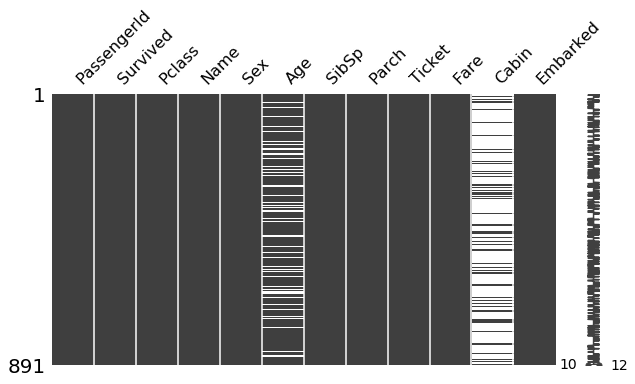

In [ ]:
import missingno
missingno.matrix(train, figsize = (10,5))

* 보시다시피 '나이'와 '캐빈' 번호에서 구멍이 많습니다.
* 빈칸의 숫자를 보겠습니다.

In [ ]:
train.isnull().sum() #비어 있는 값들을 체크해 본다.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* sum 말고 any를 쓰면 특정 행에 비어 있는 것이 True(=빈 것 있음) False(= 빈 것 없음)를 알 수 있습니다. 

In [ ]:
train.Age.isnull().any()

True

* Age는 177개가 없고, Cabin 687개가 없습니다. 그리고 Embarked에도 2개의 빈 데이터가 있습니다.
* 머신러닝 툴은 빈칸을 아주 싫어 합니다.
* 나중에 이를 어떻게 할 것인지 좀 생각해 보겠습니다.

* 각 열의 데이터 타입을 보겠습니다.

In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

* 나중에 오브젝트로 된 것은 컴퓨터가 분석하기 좋게 숫자로 바꾸어 주어야 할 것입니다.

#### 항목의 종류

#### 범주형 항목 (Categorical Features)
범주형 변수는 둘 이상의 결과 요소가 있는 변수이며 해당 기능의 각 값을 범주별로 분류 할 수 있습니다. 예를 들어 성별은 두 가지 범주 (남성과 여성)의 범주 형 변수입니다. ** 이산형 변수(discrete variable) = 범주형 변수 (categorical variable) 의 하나로 명목 변수 norminal variable **라고도합니다.

** 데이터 셋에서 명목 항목 : Sex, Embark ** 이며 우리는 Name, Ticket 등을 이로 변환해야 할 것 같습니다.

Ordinal Variable :
순위 변수는 범주 형의 하나지만 그 차이점은 값 사이의 상대 순서(=서열) 또는 정렬이 가능하다는 것입니다. 예를 들어 값이 ** Tall, Medium, Short ** 인 ** Height **와 같은 피처가있는 경우 Height는 서수 변수입니다. 여기서 변수에 상대적인 정렬을 할 수 있습니다.

** 데이터 셋에서 순위 항목 : PClass ** 이며 우리는 Cabin을 이 범주로 변환해서 사용해야 할 것 같습니다.

#### 연속형 항목 (Continuous Features):
서로 연속된 값을 가진 변수를 가진 항목이며 여기에서 우리는 연령을 대표적인 것으로 볼 수 있습니다. 

** 데이터 셋에서 순위 항목 : Age ** 이며, Age, SipSp, Parch, Fare는 interval variable로 만들어 이에 적용해야 할 것 같습니다.


####항목 정보

https://www.kaggle.com/c/titanic/data
* 위의 링크에 가면 데이터 항목의 딕쇼너리를 보실 수 있습니다.

      Variable       Definition                Key

      survival	    Survival	             0 = No, 1 = Yes

      pclass	      Ticket class	         1 = 1st, 2 = 2nd, 3 = 3rd

      sex	          Sex	

      Age	          Age in years	

      sibsp	        # of siblings / spouses aboard the Titanic	

      parch	        # of parents / children aboard the Titanic	

      ticket	      Ticket number	

      fare	        Passenger fare	

      cabin	        Cabin number	

      embarked	    Port of Embarkation	     C = Cherbourg, Q = Queenstown, S = Southampton

* 이제 데이터 분석을 위해 새로운 데이터프레임을 만듭니다.

In [ ]:
df = pd.DataFrame()

## Task 3 - "Surived" 분석

* 한 열씩 검토해 보겠습니다.

1. Survived -  ** Key: (0 - Not Survived, 1- Survived) **

* Survived는 수자로 값을 주지만 Categorical Variable인 셈입니다.
* 죽던지 살던지 둘 중 하나의 값을 줍니다.

* countplot을 그려 봅니다.
* 사이즈는 가로 10인치 세로 2인치
* 생존 여부 0과 1의 숫자를 세어 본 후 그림을 그리도록 명령을 하는 것입니다.

0    549
1    342
Name: Survived, dtype: int64


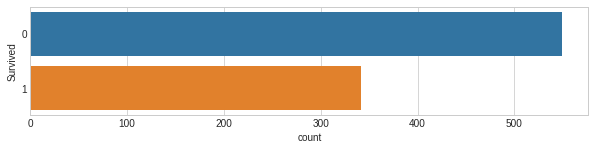

In [ ]:
fig = plt.figure(figsize=(10,2))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

* 불행히도 사망자가 훨씬 많아 보입니다.
* 전체 사망자 비율을 좀 보겠습니다. 

* 파이그래프랑 카운트 플롯을 서브플롯으로 그립니다.
* 행은 하나 열은 2개의 서브 플롯입니다. 사이즈는 가로 15인치 세로 6인치
* 'Survived'의 값을 카운트해서 파이플롯을 만듭니다. 
* explode는 폭발하는 것이니까 1이면 튀어 나가는 것인데 0을 주면 분리만 되고 돌출은 되지 않습니다. 이어서 0, 1인 것은 첫 번째 것은 아니고 두번 째 것은 분리된다는 의미로 생각하시면 됩니다.
* autopercent는 1.1이 표현하는 부분은 소수점 한 자리까지 보여 주라는 의미입니다. 뒤에 점 이하가 4면 둘 다 소수점 4자리수 까지 보여 줍니다.
* ax[0]은 첫번째 칸입니다.
* set_title 메소드는 서브 플롯의 제목을 보여 줍니다.   

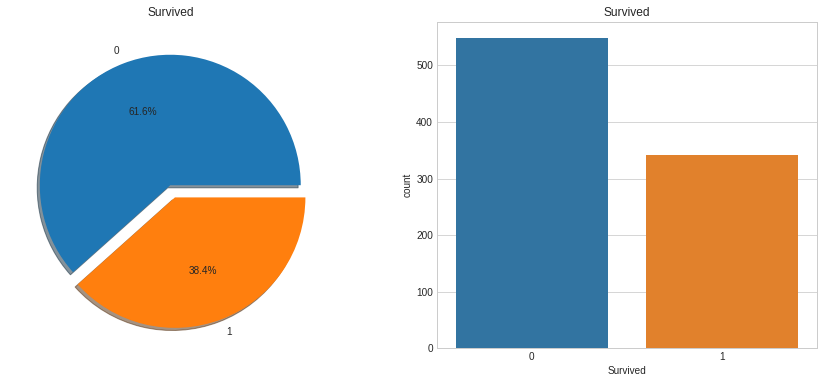

In [ ]:
f,ax=plt.subplots(1,2,figsize=(15,6))
train['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=train,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

* 위의 것을 아래와 같이 함수로 만들겠습니다. (물론 자주 쓰이지는 않겠지만 연습이니)

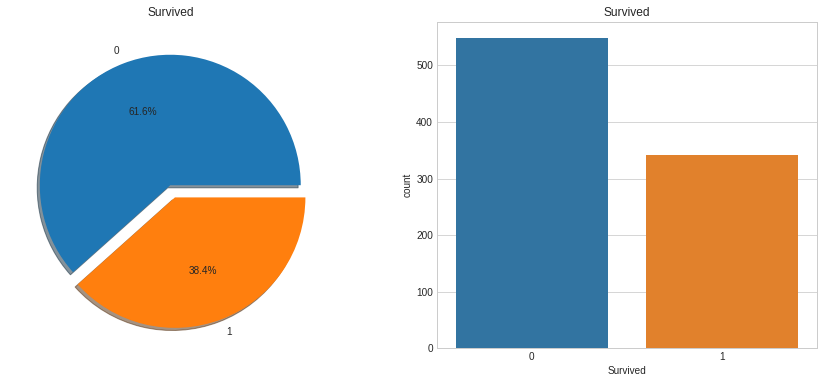

In [ ]:
def piecount(a):
    f,ax=plt.subplots(1,2,figsize=(15,6))
    train[a].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_title(a)
    ax[0].set_ylabel('')
    sns.countplot(a,data=train,ax=ax[1])
    ax[1].set_title(a)
    plt.show()

piecount('Survived')

* 문제는 위의 함수가 달랑 두개의 값만 가진 것에 통한다는 사실입니다.
* 그럼 저 함수를 Pclass에 쓰면 3개 값이라 에러가 날 것입니다.
* 이 때는 위를 클래스를 만들고 파이썬 수업에서 배운 오버라이딩을 해줘야죠. 하지만 용도에 대비해서 너무 과도 한 일이라 3개 짜리를 다시 한 번 만들어 봅니다. 살짝만 바꾸어 봅니다. 

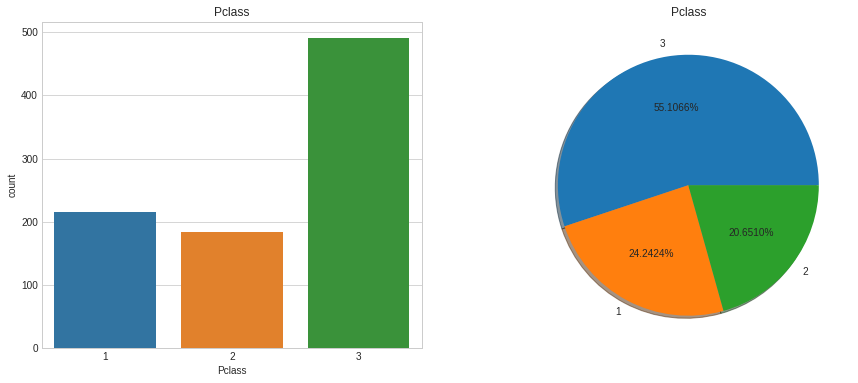

In [ ]:
def piecount3(a):
      f,ax=plt.subplots(1,2,figsize=(15,6))
      train[a].value_counts().plot.pie(explode=[0,0.0,0],autopct='%0.4f%%',ax=ax[1],shadow=True)
      ax[1].set_title(a)
      ax[1].set_ylabel('')
      sns.countplot(a,data=train,ax=ax[0])
      ax[0].set_title(a)
      plt.show()

piecount3("Pclass")

* 이제 생존한 사람들의 데이터를 우리가 만든 새로운 데이터 프레임에 옮겨 놓습니다.

In [ ]:
df['Survived'] = train['Survived']

* 잘 들어 갔나 확인해 봅니다.

In [ ]:
df.head()

,Survived
0,0
1,1
2,1
3,1
4,0


* 여기서 우리가 함수를 하나 만들어 쓰겠습니다. 앞으로도 위를 계속 보게 될 것이 뻔하니 한 줄에 보도록 만들죠

In [ ]:
def sub(a,b):
	df[a] = train[b]
	return df.head()

sub('Survived', 'Survived')

,Survived
0,0
1,1
2,1
3,1
4,0


* 이젠 sub()만 아규먼트랑 같이 호출하면 됩니다. 이 것은 자주 쓰일 것 같습니다.

## Task 4 - "Pclass" 분석

* Pclass는 값이 숫자이나 서열이 정해진 Ordinal Feature이다. 

Key:1 = 1st, 2= 2nd, 3 = 3rd

* 각 클래스 당 생존자를 보겠습니다.

In [ ]:
train.groupby(['Pclass','Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [ ]:
pd.crosstab(train.Pclass,train.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


*1등급 객실의 사람들은 생존자가 더 많고, 2등급은 생존자에 비해 사망자가 조금 더 많으나, 3등급은 사망자가 3배 이상 많다는 것을 알 수 있습니다.

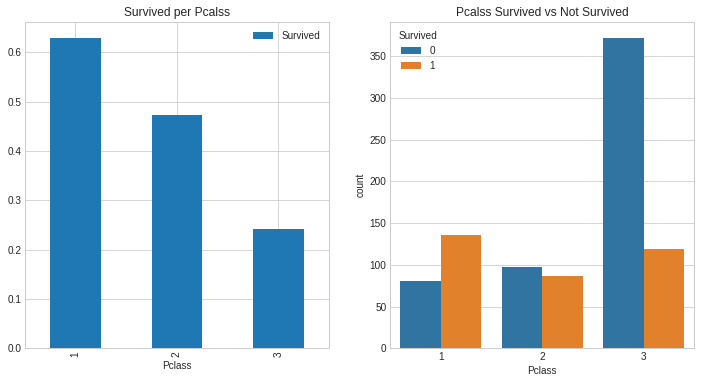

In [ ]:
f,ax=plt.subplots(1,2,figsize=(12,6))
train[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived per Pcalss')
sns.countplot('Pclass',hue='Survived',data=train,ax=ax[1])
ax[1].set_title('Pcalss Survived vs Not Survived')
plt.show()

* 위에 만든 함수를 한 번 써 먹어 볼까요?

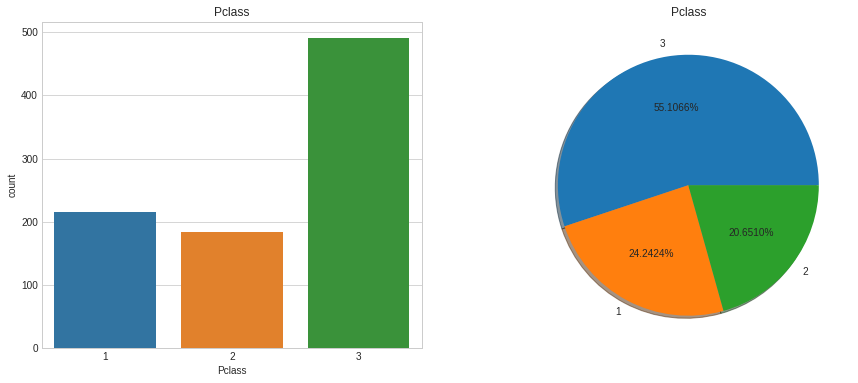

In [ ]:
piecount3("Pclass")

* %는 3등칸이 반이 넘으나 위의 그래프에서 생존자는 1등석이 가장 많다는 것을 알 수 있습니다.
* 각 클래스 당 생존률을 볼까요?

In [ ]:
train.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

*위에 것도 함수로 만들죠

In [ ]:
def survpct(a):
  return train.groupby(a).Survived.mean()

survpct('Pclass')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

* 값을 옮깁니다.

In [ ]:
sub('Pclass', 'Pclass')

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


## Task 5 - "Name" 분석

* 이름은 거의 모두 다를 가능성이 큽니다. Family Name, First Name, Middle Name and even Dr. Capt, master and so on 모두 감안하면...
* 분류를 한 번 해 봅니다.
* 리스트를 한 번 주 욱 보겠습니다.

In [ ]:
train.Name.value_counts()

Funk, Miss. Annie Clemmer                  1
Olsen, Mr. Ole Martin                      1
Abelson, Mr. Samuel                        1
Peters, Miss. Katie                        1
Davies, Master. John Morgan Jr             1
                                          ..
Reynaldo, Ms. Encarnacion                  1
Cherry, Miss. Gladys                       1
Bourke, Miss. Mary                         1
Lemore, Mrs. (Amelia Milley)               1
Bishop, Mrs. Dickinson H (Helen Walton)    1
Name: Name, Length: 891, dtype: int64

* 감이 안 옵니다. 중간에 있는 Mr. 호칭을 볼까요. 
* ['Initial']이란 열을 새로 만들어서 여기에 Name에서 추출한 Regular Expression을 넣습니다.
* 아래에서 str.extract('([A-Za-z]+)\.')부분은 str에서 대문자 A~Z, 소문자 a~z 중에 \. 명령을 통해 .으로 끝나는 부분을 추출해 내는 것입니다.  
* ('^([A-Za-z]+)')으로 하면 처음에 나오는 문자 덩어리가 될 것이고 +를 빼면 첫 스펠링 한캐릭터만 추출합니다. 



In [ ]:
train['Initial']=0
for i in train:
    train['Initial']=train.Name.str.extract('([A-Za-z]+)\.')

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


* 이를 성별로 봅니다.

In [ ]:
pd.crosstab(train.Initial,train.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


* 생존률로 봅니다.

In [ ]:
survpct('Initial')

Initial
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

* 생존 숫자로 봅니다.

In [ ]:
pd.crosstab(train.Initial,train.Survived).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,1,1,0,1,4,1,0,1,17,55,0,0,436,26,0,6,0
1,0,1,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1


####하나씩 봅니다.

* Capt: 대위이니 젊은 군인으로 희생을 자처했을 가능성이 크다(선장의 캡틴이라도 희생을 당했을 가능성이 크다) Young Soldier --> ys
* Col: 대령이니 중년 군인. Old Soldier --> os
* Countess: 여성 귀족 --> Female Noble --> fn
* Don: Donald의 약자 ?  -> mr
* Dr: 의사 선생님 --> dr
* Johnkheer: 남자 이름인듯 --> mr
* Lady: 여성 귀족 --> fn
* Major: 역시 영관급이니 --> os
* Master: 아이들 --> ma
* Miss: 젊은 여성 --> ms
* Mlle: 마드모아젤 이니 나이 많으신 여성 귀족일 가능성이 크다 - fn 
* Mme: 마담의 프랑스어 준말로 역시 나이 많으신 프랑스 여성 귀족일 가능성이 크다. - fn
* Mr: mr
* Mrs: mrs
* Ms: 요즘은 miss+mrs의 뜻이나 당시 영국에서는 한번 결혼한 여성을 ms라 불렀다. 굳이 따로 부른 것을 보면 귀족 widow가 아니었을까? - fn 
* Rev: 목사님이시니 스스로 희생했을 가능성이 크다. rv
* Sir: 남자 귀족 - mn

* 참고로 항목이 너무 많아도 문제지만 너무 병합하면 확률이 확 떨어진다.

* 이들을 위에 약자로 바꾼다.

In [ ]:
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Master', 'Miss', 'Mr', 'Mrs'],['fn','fn','fn','dr','os','fn','fn','mr','os','rv','ys','mn','mr', 'ma', 'ms', 'mr','mrs' ],inplace=True)

In [ ]:
pd.crosstab(train.Initial,train.Survived).T.style.background_gradient(cmap='summer_r')

Initial,dr,fn,ma,mn,mr,mrs,ms,os,rv,ys
Survived,,,,,,,,,,
0,4,0,17,0,438,26,55,2,6,1
1,3,6,23,1,81,99,127,2,0,0


In [ ]:
survpct('Initial')

Initial
dr     0.428571
fn     1.000000
ma     0.575000
mn     1.000000
mr     0.156069
mrs    0.792000
ms     0.697802
os     0.500000
rv     0.000000
ys     0.000000
Name: Survived, dtype: float64

* 여기서 잠시 불공평한 세상을 경험하면....Initial을 Pclass별로 나누어 보자

In [ ]:
pd.crosstab(train.Initial,train.Pclass).T.style.background_gradient(cmap='summer_r')

Initial,dr,fn,ma,mn,mr,mrs,ms,os,rv,ys
Pclass,,,,,,,,,,
1,5,5,3,1,109,42,46,4,0,1
2,2,1,9,0,91,41,34,0,6,0
3,0,0,28,0,319,42,102,0,0,0


* Pclass별 생존 별로 보자

In [ ]:
pd.crosstab([train.Initial,train.Survived],train.Pclass,margins=True).style.background_gradient(cmap='summer_r')

* 이를 Class Name('CN')으로 바꾸어 새로운 열로 입력하자

In [ ]:
train['CN']=0

def cn(k):
  for n in range(1,4):
    train.loc[(train['Initial'] == k) & (train['Pclass'] == n),'CN']= k+str(n)

cn('dr')
cn('ma')
cn('mr')
cn('ms')
cn('mrs')


def cn1(k):
   train.loc[(train['Initial'] == 'k'),'CN']= k

cn1('fn')
cn1('mn')
cn1('os')
cn1('rv')
cn1('ys')







In [ ]:
pd.crosstab([train.CN,train.Survived],train.Pclass,margins=True).style.background_gradient(cmap='summer_r')

* 어?? CN에 없는 value가 있습니다. 봅니다.

In [ ]:
train.CN.isnull().sum()

0

* null 이 아니라 0 이 군요. 위에 cn1이 작동 안 했을 가능성이 큽니다.

In [ ]:
train.loc[(train['CN'] == 0)][1:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.525,NaN,S,rv,0
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.000,NaN,S,rv,0
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.300,B35,C,fn,0
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.000,NaN,S,fn,0


* 다시 넣겠습니다.

In [ ]:
train.loc[(train['CN'] == 0),'CN']= train['Initial']

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,mr3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,mrs1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,ms,ms3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,mrs1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,mr3


* 다시 봅니다.

In [ ]:
pd.crosstab([train.CN,train.Survived],train.Pclass,margins=True).style.background_gradient(cmap='summer_r')


* 이 값을 새로운 데이터 프레임 이름칸에 넣습니다.

In [ ]:
sub('Name','CN')

,Survived,Pclass,Name
0,0,3,mr3
1,1,1,mrs1
2,1,3,ms3
3,1,1,mrs1
4,0,3,mr3


## Task 6 - "Sex" 분석



* 함수를 만들어서 보지요

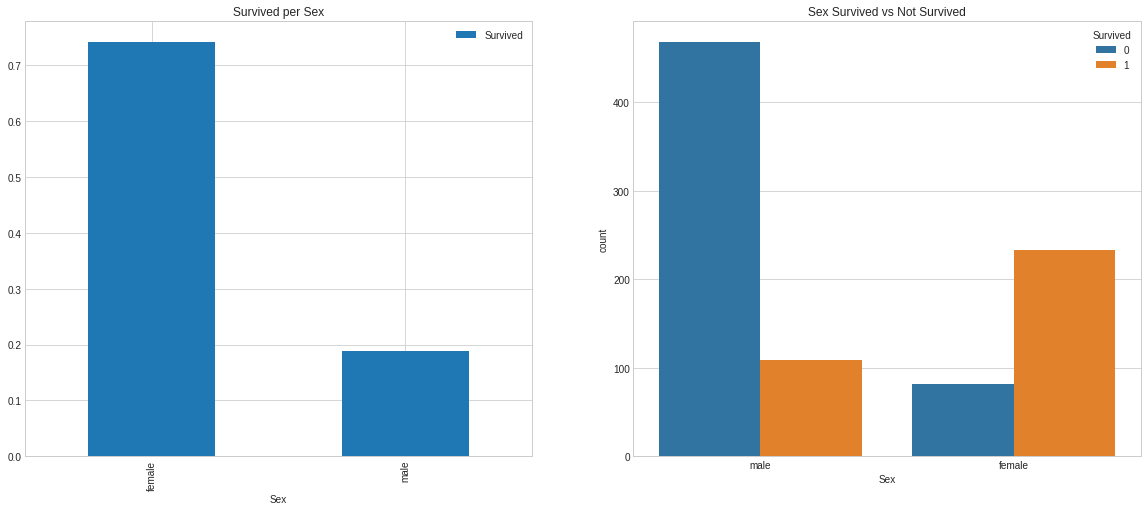

In [ ]:
def bag(a,b,c,d):
  f,ax=plt.subplots(1,2,figsize=(20,8))
  train[[a,b]].groupby([a]).mean().plot.bar(ax=ax[0])
  ax[0].set_title(c)
  sns.countplot(a,hue=b,data=train,ax=ax[1])
  ax[1].set_title(d)
  plt.show()

bag('Sex','Survived','Survived per Sex','Sex Survived vs Not Survived')  

* 배에 있던 남자의 수는 여자의 수보다 훨씬 많습니다. 여전히 생존 여성 수는 남성 수의 거의 두 배입니다. ** 선박 여성의 생존율은 약 75 % 인 반면 남성의 생존율은 약 18-19 %입니다. **

* 이 것은 남성/여성을 1,2로 나누면 될 것 같은 뻔해 보이는 것이지만 좀 더 새분화하면 좋아 보입니다.
* 예를 들어 아기들은 아기이지, 남자인지 여자인지 구명보트 태울 때 안 물어 볼 것이기 때문입니다.
* 오히려 (불행하게도) 귀족 아기인지 서민의 아기인지는 행과불행을 가를 수 있습니다 ㅠㅠ
* 생존 Pclass별로 성별을 봅니다.

In [ ]:
pd.crosstab([train.Sex,train.Survived],train.Pclass,margins=True).style.background_gradient(cmap='summer_r')

* 이는 나중에 나이가 확정되면 (나이에는 빈칸이 많더군요) 나이 별로 추가로 구분하고 일단 이들을 클래스별 남녀로 나누어 보겠습니다.

In [ ]:
train['Gender']= 0

def gender():
  for n in range(1,4):
    train.loc[(train['Sex'] == 'male') & (train['Pclass'] == n),'Gender']= 'm'+str(n)
    train.loc[(train['Sex'] == 'female') & (train['Pclass'] == n),'Gender']= 'w'+str(n)

gender()

In [ ]:
survpct('Gender')

Gender
m1    0.368852
m2    0.157407
m3    0.135447
w1    0.968085
w2    0.921053
w3    0.500000
Name: Survived, dtype: float64

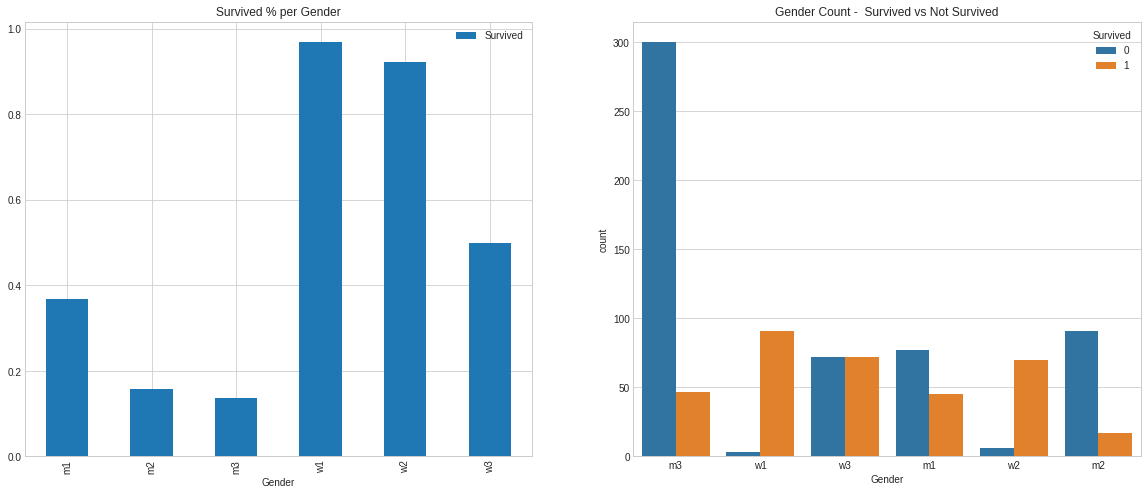

In [ ]:
bag('Gender','Survived','Survived % per Gender','Gender Count -  Survived vs Not Survived')  

* 사회는 불공평 했으나 최소한 남자들의 신사도는 있었다고 할 수 있을 것 같습니다.
* age의 빈칸이 확정된 후 이를 확정시켜 df_bin 과 df_con에 넣겠습니다. 

##Task 7 - "Age" 분석

* Age는 Continuous한 값입니다.
* 이를 구간 별로 나누어서 bin에 연속 값은 con에 넣겠습니다.

* Age의 최대, 최소, 중간을 보겠습니다.[

In [ ]:
print('Oldest Passenger was ',train['Age'].max(),'Years')
print('Youngest Passenger was ',train['Age'].min(),'Years')
print('Average Age on the ship was ',int(train['Age'].mean()),'Years')

Oldest Passenger was  80.0 Years
Youngest Passenger was  0.42 Years
Average Age on the ship was  29 Years


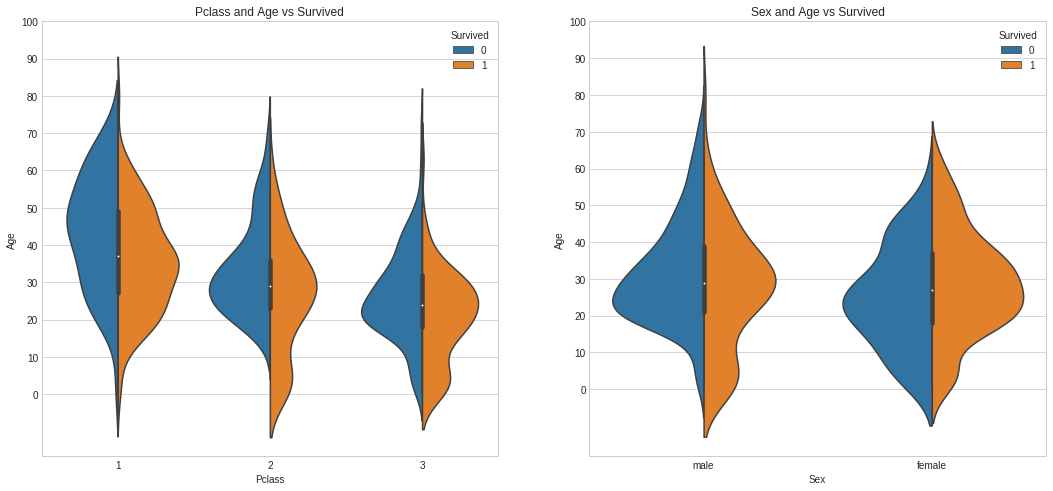

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=train,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=train,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

#### 관찰 :

1) Pclass에 따라 어린이 수가 증가하고 10 세 미만의 어린이 (즉, 어린이)의 생존율은 Pclass에 상관없이 양호해 보입니다.

2) Pclass1에서 20-50세의 Passeneger의 생존 가능성은 높고 여성에게는 더 좋습니다.

3) 남성의 경우 생존 확률은 나이가 증가함에 따라 감소합니다.

* 우선 age의 빈칸 부터 해결 합니다.

* 앞에서 살펴본 것처럼 Age 항목에는 ** 177 ** null 값이 있습니다. 이러한 NaN 값을 대체하기 위해 데이터 집합의 평균 수명을 지정할 수 있습니다.

* 그러나 문제는 평균 연령이 29 세를 4세 아이에게 할당 할 수 없습니다. 승객이 어떤 연령대에 있는지 알 수있는 방법이 있을까요? 이름에서 힌트를 찾아 봅니다.

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,mr3,m3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,mrs1,w1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,ms,ms3,w3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,mrs1,w1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,mr3,m3


* Initial 별 평균 연령을 보고 적용 시키는 것이 좋을 것 같습니다.

In [ ]:
train.groupby('Initial')['Age'].mean() #이니셜 별 평균 연령 체크

Initial
dr     42.000000
fn     30.166667
ma      4.574167
mn     49.000000
mr     32.401250
mrs    35.898148
ms     21.773973
os     53.250000
rv     43.166667
ys     70.000000
Name: Age, dtype: float64

* capt.이 70세인 것 보니 대위 캡틴이 아니라 선장 캠틴인 것 같습니다. ㅠㅠ ys란 약자가 민망합니다.
* 이니셜 별 평균 연령을 빈칸에 넣도록 합니다.

In [ ]:
train['Newage']=0
def newage(k,n):
  train.loc[(train.Age.notnull())&(train.Initial==k),'Newage']= train['Age']
  train.loc[(train.Age.isnull())&(train.Initial==k),'Newage']= n
      
newage('dr', 42)
newage('fn', 30)
newage('ma', 4)
newage('mn', 49)
newage('mr', 32)
newage('mrs', 36)
newage('ms', 22)
newage('os', 42)
newage('rv', 43)
newage('ys', 70)



In [ ]:
train['Newage']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    22.0
889    26.0
890    32.0
Name: Newage, Length: 891, dtype: float64

In [ ]:
survpct('Newage')


Newage
0.42     1.0
0.67     1.0
0.75     1.0
0.83     1.0
0.92     1.0
        ... 
70.00    0.0
70.50    0.0
71.00    0.0
74.00    0.0
80.00    1.0
Name: Survived, Length: 88, dtype: float64

In [ ]:
pd.crosstab(train.Newage,train.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Newage,,,
0.42,0,1,1
0.67,0,1,1
0.75,0,2,2
0.83,0,2,2
0.92,0,1,1
1.0,2,5,7
2.0,7,3,10
3.0,1,5,6
4.0,5,9,14


In [ ]:
pd.crosstab([train.Newage,train.Survived],train.Pclass,margins=True).style.background_gradient(cmap='summer_r')

* 위를 보면

* 1살 미만은 모두 살았습니다
* 1살 이상 15살 까지는 상대적으로 

* qcut으로 나이 그룹을 나누어 보겠습니다.

In [ ]:
train['Age_Range']=pd.qcut(train['Newage'],10)
def groupmean(a,b):
  return train.groupby([a])[b].mean().to_frame().style.background_gradient(cmap='summer_r')

groupmean('Age_Range', 'Newage')

,Newage
Age_Range,
"(0.419, 16.0]",7.8526
"(16.0, 20.0]",18.5316
"(20.0, 22.0]",21.7102
"(22.0, 26.0]",24.5
"(26.0, 30.0]",28.5889
"(30.0, 32.0]",31.8718
"(32.0, 34.0]",33.4375
"(34.0, 38.0]",36.1184
"(38.0, 47.0]",42.5169


In [ ]:
groupmean('Age_Range', 'Survived')

,Survived
Age_Range,
"(0.419, 16.0]",0.548077
"(16.0, 20.0]",0.341772
"(20.0, 22.0]",0.431818
"(22.0, 26.0]",0.363636
"(26.0, 30.0]",0.4
"(30.0, 32.0]",0.198718
"(32.0, 34.0]",0.40625
"(34.0, 38.0]",0.552632
"(38.0, 47.0]",0.325843


* 별로 마음에 안 들어서 Age Group을 제가 나누어 봅니다.

* 1살 미만 baby -1
* 1살 - 3살 Toddler  2
* 3살 초과 - 11살 young kid  - 7
* 11살 초과 - 15미만 big kid  - 13
* 15-17 살 Boy/Girl - 16
* 17이상 20미만 Youth - 18
* 20- 22 Very Young - 21
* 22- 26 Young man  -24
* 26 - 30  - 28
* 30 -32 Active  - 31
* 32 -34 Manager  - 33
* 34  - 38 Director  - 36
* 38 - 52 Mid  - 45
* 52-75 Old  - 63
* 75이상 Senior  - 80

* 이를 기준으로 Sex로 돌아갑니다
* 성별에서 마무리를 하지 않았습니다.
* 성별을 다시 봅니다.

In [ ]:
groupmean('Gender', 'Survived')

,Survived
Gender,
m1,0.368852
m2,0.157407
m3,0.135447
w1,0.968085
w2,0.921053
w3,0.5


* 여기서 1살 미만은 baby란 젠더를 만듭니다.
* 75세이상은 senior란 gender를 만듭니다.
* 따라서 Gender는 8개로 늘어 납니다.


In [ ]:
train.loc[(train.Age < 1), 'Gender']= 'baby'
train.loc[(train.Age > 75), 'Gender'] = 'senior'

In [ ]:
groupmean('Gender', 'Survived')

,Survived
Gender,
baby,1
m1,0.358333
m2,0.133333
m3,0.132948
senior,1
w1,0.968085
w2,0.921053
w3,0.492958


* 이를 새로운 데이터 프레임에 올립니다.

In [ ]:
sub('Sex', 'Gender') 

,Survived,Pclass,Name,Sex
0,0,3,mr3,m3
1,1,1,mrs1,w1
2,1,3,ms3,w3
3,1,1,mrs1,w1
4,0,3,mr3,m3


* 다시 돌아와서 Age를 그룹화 시킵니다. Agroup이라고 이름 짓겠습니다.

* 1살 미만 baby -1
* 1살 - 3살 Toddler  2
* 3살 초과 - 11살 young kid  - 7
* 11살 초과 - 15미만 big kid  - 13
* 15-17 살 Boy/Girl - 16
* 17이상 20미만 Youth - 18
* 20- 22 Very Young - 21
* 22- 26 Young man  -24
* 26 - 30  - 28
* 30 -32 Active  - 31
* 32 -34 Manager  - 33
* 34  - 38 Director  - 36
* 38 - 52 Mid  - 45
* 52-75 Old  - 63
* 75이상 Senior  - 80

In [ ]:
train['Agroup']=0

train.loc[train['Newage']<1.0,'Agroup']= 1
train.loc[(train['Newage']>=1.0)&(train['Newage']<=3.0),'Agroup']= 2
train.loc[(train['Newage']>3.0)&(train['Newage']<11.0),'Agroup']= 7
train.loc[(train['Newage']>=11.0)&(train['Newage']<15.0),'Agroup']= 13
train.loc[(train['Newage']>=15.0)&(train['Newage']<18.0),'Agroup']= 16
train.loc[(train['Newage']>=18.0)&(train['Newage']<= 20.0),'Agroup']= 18
train.loc[(train['Newage']> 20.0)&(train['Newage']<=22.0),'Agroup']= 21
train.loc[(train['Newage']>22.0)&(train['Newage']<=26.0),'Agroup']= 24
train.loc[(train['Newage']>26.0)&(train['Newage']<=30.0),'Agroup']= 28
train.loc[(train['Newage']>30.0)&(train['Newage']<=32.0),'Agroup']= 31
train.loc[(train['Newage']>32.0)&(train['Newage']<=34.0),'Agroup']= 33
train.loc[(train['Newage']>34.0)&(train['Newage']<=38.0),'Agroup']= 36
train.loc[(train['Newage']>38.0)&(train['Newage']<=52.0),'Agroup']= 45
train.loc[(train['Newage']>52.0)&(train['Newage']<=75.0),'Agroup']= 60
train.loc[train['Newage']>75.0,'Agroup']= 80

In [ ]:
groupmean('Agroup', 'Survived')

,Survived
Agroup,
1,1
2,0.565217
7,0.526316
13,0.5
16,0.457143
18,0.318182
21,0.431818
24,0.363636
28,0.4


In [ ]:
groupmean('Agroup', 'Age')

,Age
Agroup,
1,0.738571
2,1.95652
7,6.55882
13,12.8929
16,16.2286
18,18.8333
21,21.5096
24,24.5
28,28.5889


In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,mr3,m3,22.0,"(20.0, 22.0]",21
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,mrs1,w1,38.0,"(34.0, 38.0]",36
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,ms,ms3,w3,26.0,"(22.0, 26.0]",24
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,mrs1,w1,35.0,"(34.0, 38.0]",36
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,mr3,m3,35.0,"(34.0, 38.0]",36


In [ ]:
sub('Age', 'Agroup')

,Survived,Pclass,Name,Sex,Age
0,0,3,mr3,m3,21
1,1,1,mrs1,w1,36
2,1,3,ms3,w3,24
3,1,1,mrs1,w1,36
4,0,3,mr3,m3,36


## Task 8 -"SibSp" 분석

* 이 항목은 탑승자가 혼자인지 또는 가족과 함께 있는지를 나타냅니다.

*Sibling = 형제, 자매, 의붓 형제, 이복 누이

Spouse = 남편, 아내

In [ ]:
pd.crosstab([train.SibSp],train.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


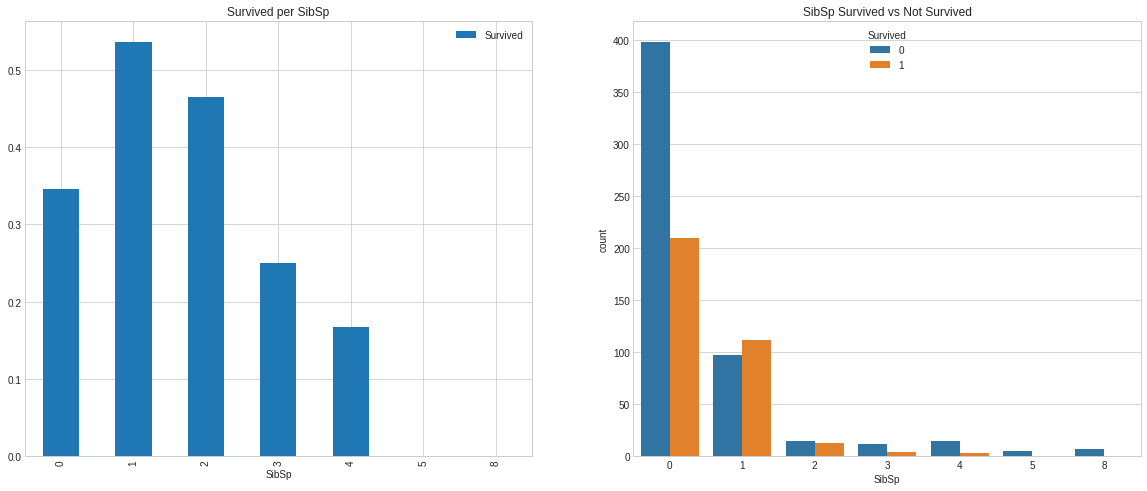

In [ ]:
bag('SibSp','Survived','Survived per SibSp','SibSp Survived vs Not Survived') 

In [ ]:
survpct('SibSp')

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [ ]:
pd.crosstab(train.SibSp,train.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


In [ ]:
pd.crosstab([train.SibSp,train.Survived],train.Pclass,margins=True).style.background_gradient(cmap='summer_r')

* 관찰 :

승객이없는 형제 자매 혼자 탄 경우, barplot 및 factorplot 쇼는 것을, 그는 34.5 %의 생존율로 평균과 비슷합니다. 
하지만 저의 최초 추측과는 달리 형제 수가 증가하면 그래프가 감소합니다. 즉, 배에 가족이 남아 있으면 먼저 탈출하지 못 하고 가족을 구하려고 노력할 것입니다. 놀랍게도 5-8인 가족의 생존율은 ** 0 % **입니다. 

그 이유는 ** Pclass **입니다. 크로스 탭은 SibSp> 3 인 Person이 모두 Pclass3에 있음을 보여줍니다. Pclass3 (> 3)즉, 저소득 층 대가족은 모두 사망했다는 것입니다.

* 이를 Sgroup로 정하여서 

* 혼자 1등석 Alone 1 = A1,  그리고 A2, A3 -  1,2,3

* 2명은 Couple  C1, C2, C3  - 4,5,6

* 3명은 Three  T1, T2, T3 - 7,8,9

* 4명은 Four, F - 10

* 5명 초과는 Large Family로 L로 잡습니다. -11

In [ ]:
train['Sgroup']=0

train.loc[(train['SibSp']==0)& (train['Pclass']==1),'Sgroup']= 1
train.loc[(train['SibSp']==0)& (train['Pclass']==2),'Sgroup']= 2
train.loc[(train['SibSp']==0)& (train['Pclass']==3),'Sgroup']= 3
train.loc[(train['SibSp']==1)& (train['Pclass']==1),'Sgroup']= 4
train.loc[(train['SibSp']==1)& (train['Pclass']==2),'Sgroup']= 5
train.loc[(train['SibSp']==1)& (train['Pclass']==3),'Sgroup']= 6
train.loc[(train['SibSp']==2)& (train['Pclass']==1),'Sgroup']= 7
train.loc[(train['SibSp']==2)& (train['Pclass']==2),'Sgroup']= 8
train.loc[(train['SibSp']==2)& (train['Pclass']==3),'Sgroup']= 9
train.loc[(train['SibSp']==3),'Sgroup']= 10
train.loc[(train['SibSp']>3),'Sgroup']= 11

In [ ]:
train.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,mr3,m3,22.0,"(20.0, 22.0]",21,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,mrs1,w1,38.0,"(34.0, 38.0]",36,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,ms,ms3,w3,26.0,"(22.0, 26.0]",24,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,mrs1,w1,35.0,"(34.0, 38.0]",36,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,mr3,m3,35.0,"(34.0, 38.0]",36,3
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,mr,mr3,m3,32.0,"(30.0, 32.0]",31,3
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,mr,mr1,m1,54.0,"(47.0, 80.0]",60,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,ma,ma3,m3,2.0,"(0.419, 16.0]",2,10
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,mrs,mrs3,w3,27.0,"(26.0, 30.0]",28,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,mrs,mrs2,w2,14.0,"(0.419, 16.0]",13,5


* 이를 새 데이터 프레임에 올립니다.

In [ ]:
sub('SibSp','Sgroup')

,Survived,Pclass,Name,Sex,Age,SibSp
0,0,3,mr3,m3,21,6
1,1,1,mrs1,w1,36,4
2,1,3,ms3,w3,24,3
3,1,1,mrs1,w1,36,4
4,0,3,mr3,m3,36,3


## Task 9 - "Parch"분석 

In [ ]:
pd.crosstab(train.Parch,train.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


* 크로스 탭은 다시 식구 많은 쪽은 Pclass3에 있음을 보여줍니다.

* 여기에서도 결과는 매우 비슷합니다. 부모와 함께 탑승 한 승객은 생존 가능성이 더 높습니다. 그러나 숫자가 올라 갈수록 줄어 듭니다.

* 생존 가능성은 배에 1-3 명의 부모가있는 누군가에게 좋습니다. 혼자 또한 생존 가능성이 낮은 것으로 판명되고 가족이 4 명이상 있으면 생존 가능성이 줄어 듭니다. 이는 소수의 가족들이 있는 귀족층이 생존하고, 혼자가 많은 젊은 이들은 양보를 할 수 밖에 없고, 가족이 많은 사람들(특히 귀족이 아닌 3등칸 사람들)은 전원이 타지 못 하면 어느 누구도 탈 수가 없는 비극적인 당시 상황을 보여 줍니다.

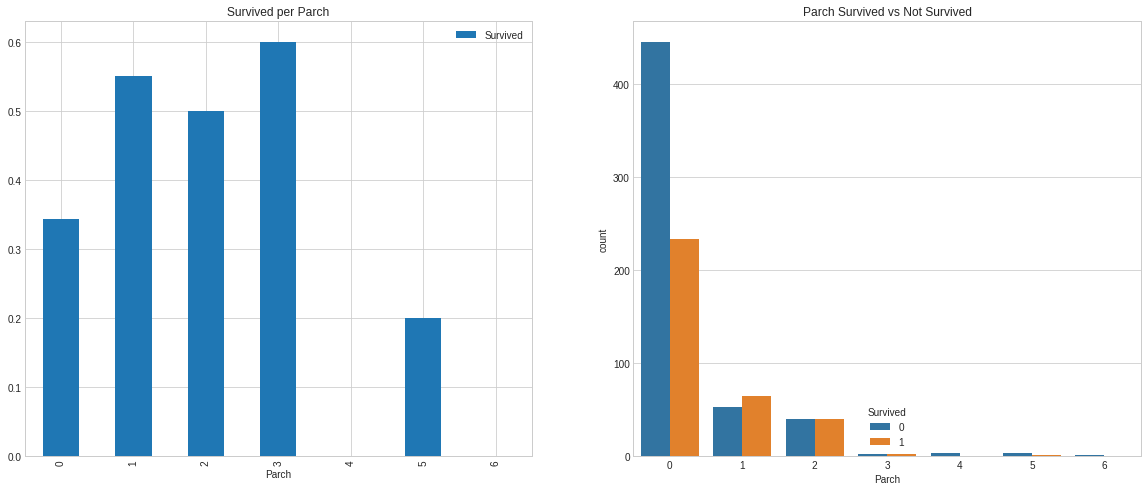

In [ ]:
bag('Parch','Survived','Survived per Parch','Parch Survived vs Not Survived') 

In [ ]:
pd.crosstab([train.Parch,train.Survived],train.Pclass,margins=True).style.background_gradient(cmap='summer_r')

* 비슷하게 해보려고 하나 SibSp과 너무 비슷한 결과를 보여 겹치는 아이템이 아닐까 라는 우려가 듭니다. (본래는 Alone그룹과 Family그룹별로 나누어서 SibSp와 Parch를 바꾸어야 하나 여기서는 그냥 하겠습니다.)

* 이를 Pgroup로 정하여서 

* 혼자 1등석 Alone 1 = A1,  그리고 A2, A3 -  1,2,3

* 2명은 Couple  C1, C2, C3  - 4,5,6

* 3명은 Three  T1, T2, T3 - 7,8,9

* 4명은 Four, F1, F2, F3 - 10, 11, 12

* 5명은 Five, F5 - 13

* 6명은 Six, S - 14

* 7명은 Large Family로 L로 잡습니다. -15

* 그 이상은 16으로

In [ ]:
train.loc[(train['Parch']==0)& (train['Pclass']==1),'Pgroup']= 1
train.loc[(train['Parch']==0)& (train['Pclass']==2),'Pgroup']= 2
train.loc[(train['Parch']==0)& (train['Pclass']==3),'Pgroup']= 3
train.loc[(train['Parch']==1)& (train['Pclass']==1),'Pgroup']= 4
train.loc[(train['Parch']==1)& (train['Pclass']==2),'Pgroup']= 5
train.loc[(train['Parch']==1)& (train['Pclass']==3),'Pgroup']= 6
train.loc[(train['Parch']==2)& (train['Pclass']==1),'Pgroup']= 7
train.loc[(train['Parch']==2)& (train['Pclass']==2),'Pgroup']= 8
train.loc[(train['Parch']==2)& (train['Pclass']==3),'Pgroup']= 9
train.loc[(train['Parch']==3)& (train['Pclass']==1),'Pgroup']= 10
train.loc[(train['Parch']==3)& (train['Pclass']==2),'Pgroup']= 11
train.loc[(train['Parch']==3)& (train['Pclass']==3),'Pgroup']= 12
train.loc[(train['Parch']==4),'Pgroup']= 13
train.loc[(train['Parch']==5),'Pgroup']= 14
train.loc[(train['Parch']==6),'Pgroup']= 15
train.loc[(train['Parch']>6),'Pgroup']= 16

In [ ]:
train.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup,Pgroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,mr3,m3,22.0,"(20.0, 22.0]",21,6,3.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,mrs1,w1,38.0,"(34.0, 38.0]",36,4,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,ms,ms3,w3,26.0,"(22.0, 26.0]",24,3,3.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,mrs1,w1,35.0,"(34.0, 38.0]",36,4,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,mr3,m3,35.0,"(34.0, 38.0]",36,3,3.0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,mr,mr3,m3,32.0,"(30.0, 32.0]",31,3,3.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,mr,mr1,m1,54.0,"(47.0, 80.0]",60,1,1.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,ma,ma3,m3,2.0,"(0.419, 16.0]",2,10,6.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,mrs,mrs3,w3,27.0,"(26.0, 30.0]",28,3,9.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,mrs,mrs2,w2,14.0,"(0.419, 16.0]",13,5,2.0


* 다시 올립니다.

In [ ]:
sub('Parch','Pgroup')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch
0,0,3,mr3,m3,21,6,3.0
1,1,1,mrs1,w1,36,4,1.0
2,1,3,ms3,w3,24,3,3.0
3,1,1,mrs1,w1,36,4,1.0
4,0,3,mr3,m3,36,3,3.0


## 10 - "Ticket"분석

* Ticket의 형태를 보겠습니다.

In [ ]:
train.Ticket.head(n=20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

* 도무지 감이 안 잡히는 배열입니다.
* 빈칸이 없는지 보겠습니다.

In [ ]:
train.Ticket.isnull().any()

False

* 티켓에서 영문있는 것과 숫자만 있는 것을 따봅니다.(숫자만 있는 것은 X로 하겠습니다.)

In [ ]:
train['Initick'] = 0
for s in train:
    train['Initick']=train.Ticket.str.extract('^([A-Za-z]+)')
for s in train:
    train.loc[(train.Initick.isnull()),'Initick']='X'
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup,Pgroup,Initick
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,mr3,m3,22.0,"(20.0, 22.0]",21,6,3.0,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,mrs1,w1,38.0,"(34.0, 38.0]",36,4,1.0,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,ms,ms3,w3,26.0,"(22.0, 26.0]",24,3,3.0,STON
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,mrs1,w1,35.0,"(34.0, 38.0]",36,4,1.0,X
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,mr3,m3,35.0,"(34.0, 38.0]",36,3,3.0,X


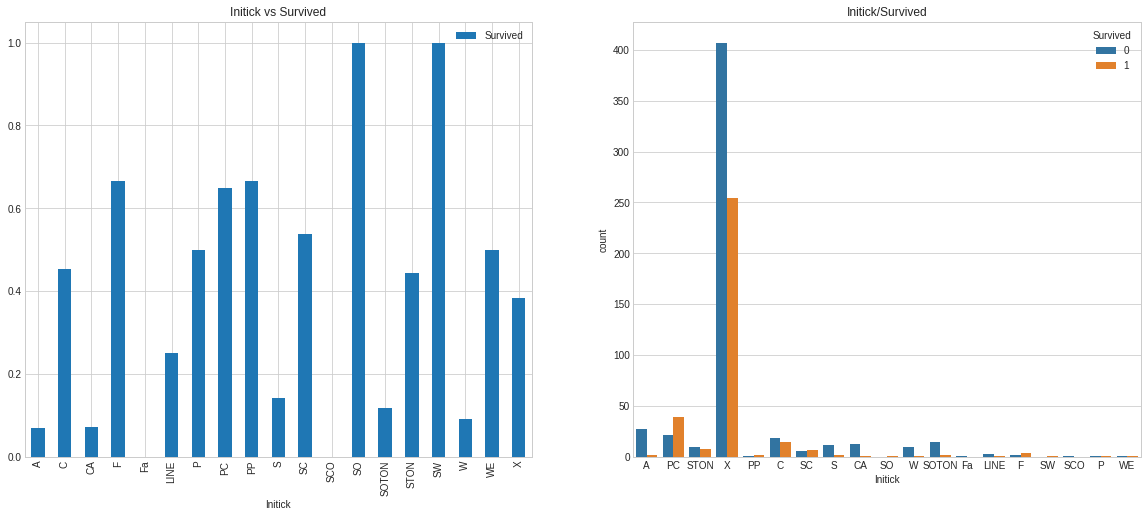

In [ ]:
bag('Initick','Survived', 'Initick vs Survived', 'Initick/Survived')

In [ ]:
train.groupby(['Initick'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Initick,
A,0.0689655
C,0.454545
CA,0.0714286
F,0.666667
Fa,0
LINE,0.25
P,0.5
PC,0.65
PP,0.666667


*  이 것도 함수로 만들어 놓죠

In [ ]:
def groupmean(a,b):
  return train.groupby([a])[b].mean().to_frame().style.background_gradient(cmap='summer_r')

groupmean('Initick', 'Survived')

,Survived
Initick,
A,0.0689655
C,0.454545
CA,0.0714286
F,0.666667
Fa,0
LINE,0.25
P,0.5
PC,0.65
PP,0.666667


* x를 그룹별로 보겠습니다.



In [ ]:
pd.crosstab([train.Pclass,train.Survived],train.Initick == 'X',margins=True).style.background_gradient(cmap='summer_r')

* 이 들을 그룹으로 나누어 봅니다.
* 가장 생존율 낮은 것부터

Fa, SCO = 0

A, CA, W = 0.1

S, SOTON = 0.12

LINE = 0.25

X -> X1 = 0.63, X2 = 0.48  X3 = 0.26

STON, C = 0.45

P, WE = 0.5

SC = 0.54 

F, PP, PC = 0.66

SO, SW = 1.0










 



In [ ]:
train['Tgroup'] = 0

train.loc[(train['Initick']=='X')& (train['Pclass']==1),'Tgroup']= 0.63
train.loc[(train['Initick']=='X')& (train['Pclass']==2),'Tgroup']= 0.48
train.loc[(train['Initick']=='X')& (train['Pclass']==3),'Tgroup']= 0.26
train.loc[(train['Initick']=='Fa'),'Tgroup']= 0
train.loc[(train['Initick']=='SCO'),'Tgroup']= 0
train.loc[(train['Initick']=='A'),'Tgroup']= 0.1
train.loc[(train['Initick']=='CA'),'Tgroup']= 0.1
train.loc[(train['Initick']=='W'),'Tgroup']= 0.1
train.loc[(train['Initick']=='S'),'Tgroup']= 0.12
train.loc[(train['Initick']=='SOTON'),'Tgroup']= 0.12
train.loc[(train['Initick']=='LINE'),'Tgroup']= 0.25
train.loc[(train['Initick']=='STON'),'Tgroup']= 0.45
train.loc[(train['Initick']=='C'),'Tgroup']= 0.45
train.loc[(train['Initick']=='P'),'Tgroup']= 0.5
train.loc[(train['Initick']=='WE'),'Tgroup']= 0.5
train.loc[(train['Initick']=='SC'),'Tgroup']= 0.54
train.loc[(train['Initick']=='F'),'Tgroup']= 0.66
train.loc[(train['Initick']=='PP'),'Tgroup']= 0.66
train.loc[(train['Initick']=='PC'),'Tgroup']= 0.66
train.loc[(train['Initick']=='SO'),'Tgroup']= 1.0
train.loc[(train['Initick']=='SW'),'Tgroup']= 1.0


In [ ]:
train.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup,Pgroup,Initick,Tgroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,mr3,m3,22.0,"(20.0, 22.0]",21,6,3.0,A,0.10
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,mrs1,w1,38.0,"(34.0, 38.0]",36,4,1.0,PC,0.66
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,ms,ms3,w3,26.0,"(22.0, 26.0]",24,3,3.0,STON,0.45
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,mrs1,w1,35.0,"(34.0, 38.0]",36,4,1.0,X,0.63
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,mr3,m3,35.0,"(34.0, 38.0]",36,3,3.0,X,0.26
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,mr,mr3,m3,32.0,"(30.0, 32.0]",31,3,3.0,X,0.26
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,mr,mr1,m1,54.0,"(47.0, 80.0]",60,1,1.0,X,0.63
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,ma,ma3,m3,2.0,"(0.419, 16.0]",2,10,6.0,X,0.26
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,mrs,mrs3,w3,27.0,"(26.0, 30.0]",28,3,9.0,X,0.26
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,mrs,mrs2,w2,14.0,"(0.419, 16.0]",13,5,2.0,X,0.48


In [ ]:
sub('Ticket', 'Tgroup')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket
0,0,3,mr3,m3,21,6,3.0,0.10
1,1,1,mrs1,w1,36,4,1.0,0.66
2,1,3,ms3,w3,24,3,3.0,0.45
3,1,1,mrs1,w1,36,4,1.0,0.63
4,0,3,mr3,m3,36,3,3.0,0.26


## Task 11 - "Fare" 분석 

In [ ]:
print('Highest Fare was:',train['Fare'].max())
print('Lowest Fare was:',train['Fare'].min())
print('Average Fare was:',train['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


흠...공짜표도 있었군요

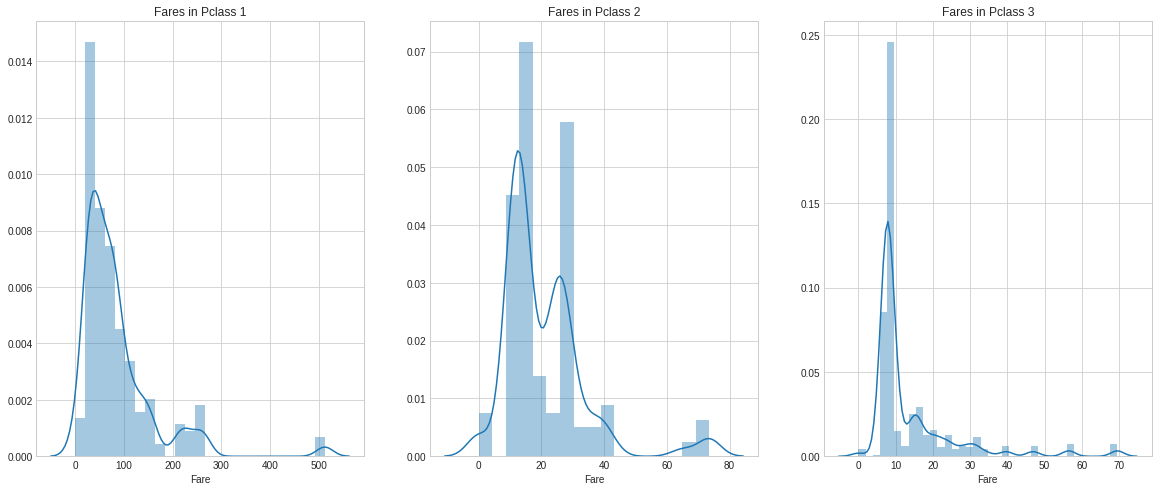

In [ ]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(train[train['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(train[train['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(train[train['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

* Pclass1의 승객 요금에는 큰 분포가있는 것으로 보이며 불연속 값으로 변환 할 수 있습니다.

* Fare를 그룹으로 나누어 놓겠습니다.
* qcut을 활용하면 원하는 조각으로 데이터를 나누어 줍니다.

In [ ]:
train['Fare_Range']=pd.qcut(train['Fare'],10)
groupmean('Fare_Range', 'Fare')

,Fare
Fare_Range,
"(-0.001, 7.55]",5.92872
"(7.55, 7.854]",7.76849
"(7.854, 8.05]",7.96367
"(8.05, 10.5]",9.52137
"(10.5, 14.454]",12.9402
"(14.454, 21.679]",17.3864
"(21.679, 27.0]",25.4875
"(27.0, 39.688]",32.2822
"(39.688, 77.958]",59.4446


In [ ]:
pd.crosstab(train.Fare,train.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Fare,,,
0.0,14,1,15
4.0125,1,0,1
5.0,1,0,1
6.2375,1,0,1
6.4375,1,0,1
6.45,1,0,1
6.4958,2,0,2
6.75,2,0,2
6.8583,1,0,1


* * Fare를 그룹화 시킵니다. Fgroup이라고 이름 짓겠습니다.

7.125이하 -> 5.0

7.9 이하 --> 7.5

8.03 이하  --> 8.0

10.5 미만 --> 9.5

23 미만 --> 16.0

27.8 이하 --> 25.5

51 이하 --> 38

73.5 이하 --> 62

73.5 초과 --> 100


In [ ]:
train['Fgroup']=0

train.loc[train['Fare']<= 7.125,'Fgroup']=5.0
train.loc[(train['Fare']>7.125)&(train['Fare']<=7.9),'Fgroup']= 7.5
train.loc[(train['Fare']>7.9)&(train['Fare']<=8.03),'Fgroup']= 8.0
train.loc[(train['Fare']>8.03)&(train['Fare']<10.5),'Fgroup']= 9.5
train.loc[(train['Fare']>=10.5)&(train['Fare']<23.0),'Fgroup']= 16.0
train.loc[(train['Fare']>=23.0)&(train['Fare']<=27.8),'Fgroup']= 25.5
train.loc[(train['Fare']>27.8)&(train['Fare']<=51.0),'Fgroup']= 38.0
train.loc[(train['Fare']>51.0)&(train['Fare']<=73.5),'Fgroup']= 62.0
train.loc[train['Fare']>73.5,'Fgroup']= 100.0

* Fare는 con에 Fgroup은 bin에 입력합니다.

In [ ]:
sub('Fare','Fgroup')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare
0,0,3,mr3,m3,21,6,3.0,0.10,7.5
1,1,1,mrs1,w1,36,4,1.0,0.66,62.0
2,1,3,ms3,w3,24,3,3.0,0.45,8.0
3,1,1,mrs1,w1,36,4,1.0,0.63,62.0
4,0,3,mr3,m3,36,3,3.0,0.26,9.5


## Taks 12 - "Cabin" 분석

* cabin 의 위치에 따라 달라지는 것이 있는지 보겠습니다.

In [ ]:
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
F33            3
C22 C26        3
              ..
E68            1
D47            1
C87            1
E31            1
D30            1
Name: Cabin, Length: 147, dtype: int64

In [ ]:
train.Cabin.isnull().sum()

687

* 빈칸이 무척 많습니다.

* Cabin에 비어 있는 것이 무려 687이나 되어 이를 다른 분류로 일단 잡고
기존 것은 이니셜로 분류합니다.
* 빈 것은 X로 구분하려는데 이 또한 1,2,3 Pclass와 연동될 것 같으니 비어있고 1등급은 X, 2등급은 Y, 3등급은 Z로 하겠습니다.

In [ ]:
train['Inicab'] = 0
for i in train:
    train['Inicab']=train.Cabin.str.extract('^([A-Za-z]+)')
    train.loc[((train.Cabin.isnull()) & (train.Pclass.values == 1 )),'Inicab']='X'
    train.loc[((train.Cabin.isnull()) & (train.Pclass.values == 2 )),'Inicab']='Y'
    train.loc[((train.Cabin.isnull()) & (train.Pclass.values == 3 )),'Inicab']='Z'

In [ ]:
train.head(n=20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup,Pgroup,Initick,Tgroup,Fare_Range,Fgroup,Inicab
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr,mr3,m3,22.0,"(20.0, 22.0]",21,6,3.0,A,0.10,"(-0.001, 7.55]",7.5,Z
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs,mrs1,w1,38.0,"(34.0, 38.0]",36,4,1.0,PC,0.66,"(39.688, 77.958]",62.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,ms,ms3,w3,26.0,"(22.0, 26.0]",24,3,3.0,STON,0.45,"(7.854, 8.05]",8.0,Z
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs,mrs1,w1,35.0,"(34.0, 38.0]",36,4,1.0,X,0.63,"(39.688, 77.958]",62.0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr,mr3,m3,35.0,"(34.0, 38.0]",36,3,3.0,X,0.26,"(7.854, 8.05]",9.5,Z
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,mr,mr3,m3,32.0,"(30.0, 32.0]",31,3,3.0,X,0.26,"(8.05, 10.5]",9.5,Z
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,mr,mr1,m1,54.0,"(47.0, 80.0]",60,1,1.0,X,0.63,"(39.688, 77.958]",62.0,E
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,ma,ma3,m3,2.0,"(0.419, 16.0]",2,10,6.0,X,0.26,"(14.454, 21.679]",16.0,Z
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,mrs,mrs3,w3,27.0,"(26.0, 30.0]",28,3,9.0,X,0.26,"(10.5, 14.454]",16.0,Z
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,mrs,mrs2,w2,14.0,"(0.419, 16.0]",13,5,2.0,X,0.48,"(27.0, 39.688]",38.0,Y


In [ ]:
train.Inicab.value_counts()

Z    479
Y    168
C     59
B     47
X     40
D     33
E     32
A     15
F     13
G      4
T      1
Name: Inicab, dtype: int64

In [ ]:
def gby(a,b,c):
  print (train.groupby([a,b])[c].count())

gby('Inicab','Survived', 'Survived')

Inicab  Survived
A       0             8
        1             7
B       0            12
        1            35
C       0            24
        1            35
D       0             8
        1            25
E       0             8
        1            24
F       0             5
        1             8
G       0             2
        1             2
T       0             1
X       0            21
        1            19
Y       0            94
        1            74
Z       0           366
        1           113
Name: Survived, dtype: int64


In [ ]:
train['Inicab'].replace(['A','B', 'C', 'D', 'E', 'F', 'G','T', 'X', 'Y', 'Z'],[1,2,3,4,5,6,7,8,9,10,11],inplace=True)

In [ ]:
sub('Cabin','Inicab')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
0,0,3,mr3,m3,21,6,3.0,0.10,7.5,11
1,1,1,mrs1,w1,36,4,1.0,0.66,62.0,3
2,1,3,ms3,w3,24,3,3.0,0.45,8.0,11
3,1,1,mrs1,w1,36,4,1.0,0.63,62.0,3
4,0,3,mr3,m3,36,3,3.0,0.26,9.5,11


## Task 13 - "Embarked" 분석

In [ ]:
pd.crosstab([train.Embarked,train.Pclass],[train.Sex,train.Survived],margins=True).style.background_gradient(cmap='summer_r')


* 승선 장소 별로 생존 확률

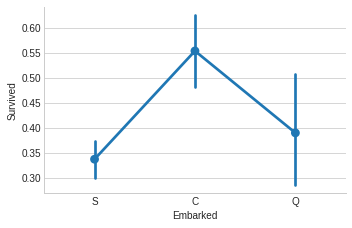

In [ ]:
sns.factorplot('Embarked','Survived',data=train)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()

* 포트 C의 생존 가능성은 0.55 정도이며 S는 가장 낮습니다.

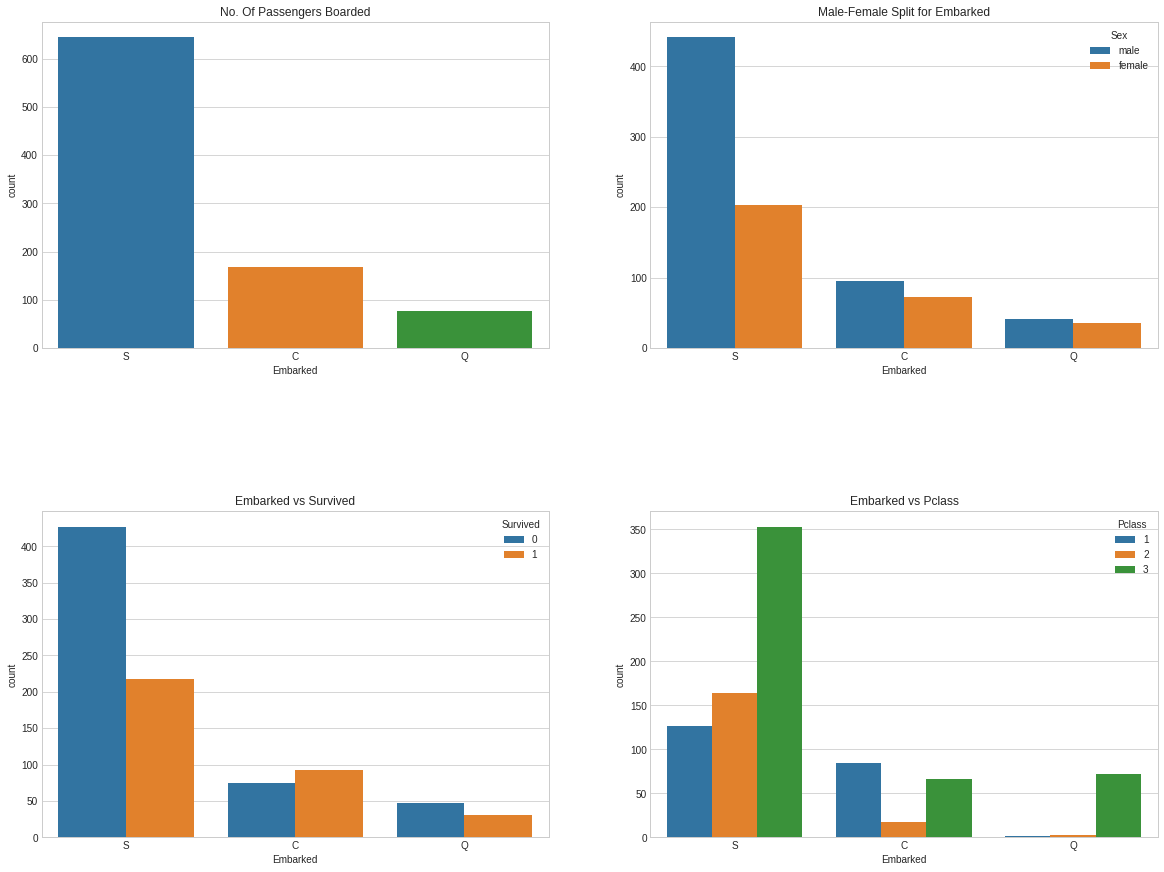

In [ ]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=train,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=train,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=train,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=train,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

* 관찰 :
1) S에서 탑승 최대. 대다수는 Pclass3

2) C의 승객들은 많은 비율이 살아남았습니다. 그 이유는 Pclass1 및 Pclass2 승객이 많아서 일 것입니다

3) Embark S는 대부분의 부자들이 탑승한 항구지만 생존 가능성은 낮습니다. Pclass3의 승객도 많았습니다. 

4) 포트 Q는 승객의 거의 95 %가 Pclass3

* 빈칸이 두개 있는데 보겠습니다.

In [ ]:
train.loc[(train.Embarked.isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup,Pgroup,Initick,Tgroup,Fare_Range,Fgroup,Inicab
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,ms,ms1,w1,38.0,"(34.0, 38.0]",36,1,1.0,X,0.63,"(77.958, 512.329]",100.0,2
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,mrs,mrs1,w1,62.0,"(47.0, 80.0]",60,1,1.0,X,0.63,"(77.958, 512.329]",100.0,2


* 두 사람의 티켓 번호가 같습니다.
* 혹시 같은 티켓 번호가 있는 다른 사람이 있는지 봅니다.

In [ ]:
train.loc[(train.Ticket == '113572')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup,Pgroup,Initick,Tgroup,Fare_Range,Fgroup,Inicab
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,ms,ms1,w1,38.0,"(34.0, 38.0]",36,1,1.0,X,0.63,"(77.958, 512.329]",100.0,2
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,mrs,mrs1,w1,62.0,"(47.0, 80.0]",60,1,1.0,X,0.63,"(77.958, 512.329]",100.0,2


* 가장 비슷한 번호를 찾아 보겠습니다.

In [ ]:
train.sort_values(['Ticket'], ascending = True)[35:45]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup,Pgroup,Initick,Tgroup,Fare_Range,Fgroup,Inicab
356,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S,ms,ms1,w1,22.0,"(20.0, 22.0]",21,1,4.0,X,0.63,"(39.688, 77.958]",62.0,5
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,mr,mr1,m1,65.0,"(47.0, 80.0]",60,1,4.0,X,0.63,"(39.688, 77.958]",62.0,2
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,S,mr,mr1,m1,32.0,"(30.0, 32.0]",31,1,1.0,X,0.63,"(27.0, 39.688]",38.0,3
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S,mr,mr1,m1,62.0,"(47.0, 80.0]",60,1,1.0,X,0.63,"(21.679, 27.0]",25.5,3
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN,ms,ms1,w1,38.0,"(34.0, 38.0]",36,1,1.0,X,0.63,"(77.958, 512.329]",100.0,2
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN,mrs,mrs1,w1,62.0,"(47.0, 80.0]",60,1,1.0,X,0.63,"(77.958, 512.329]",100.0,2
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S,ms,ms1,w1,14.0,"(0.419, 16.0]",13,4,7.0,X,0.63,"(77.958, 512.329]",100.0,2
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S,mr,mr1,m1,36.0,"(34.0, 38.0]",36,4,7.0,X,0.63,"(77.958, 512.329]",100.0,2
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S,ma,ma1,m1,11.0,"(0.419, 16.0]",13,4,7.0,X,0.63,"(77.958, 512.329]",100.0,2
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S,mrs,mrs1,w1,36.0,"(34.0, 38.0]",36,4,7.0,X,0.63,"(77.958, 512.329]",100.0,2


* 앞 뒤로 모두 S이고 Pclass도 모두 1인 것으로 봐서 S일 가능성이 큽니다.

In [ ]:
train.loc[(train.Embarked.isnull()),'Embarked']='S'

In [ ]:
train.sort_values(['Ticket'], ascending = True)[35:45]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,CN,Gender,Newage,Age_Range,Agroup,Sgroup,Pgroup,Initick,Tgroup,Fare_Range,Fgroup,Inicab
356,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0000,E33,S,ms,ms1,w1,22.0,"(20.0, 22.0]",21,1,4.0,X,0.63,"(39.688, 77.958]",62.0,5
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,mr,mr1,m1,65.0,"(47.0, 80.0]",60,1,4.0,X,0.63,"(39.688, 77.958]",62.0,2
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,S,mr,mr1,m1,32.0,"(30.0, 32.0]",31,1,1.0,X,0.63,"(27.0, 39.688]",38.0,3
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S,mr,mr1,m1,62.0,"(47.0, 80.0]",60,1,1.0,X,0.63,"(21.679, 27.0]",25.5,3
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,S,ms,ms1,w1,38.0,"(34.0, 38.0]",36,1,1.0,X,0.63,"(77.958, 512.329]",100.0,2
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,S,mrs,mrs1,w1,62.0,"(47.0, 80.0]",60,1,1.0,X,0.63,"(77.958, 512.329]",100.0,2
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S,ms,ms1,w1,14.0,"(0.419, 16.0]",13,4,7.0,X,0.63,"(77.958, 512.329]",100.0,2
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S,mr,mr1,m1,36.0,"(34.0, 38.0]",36,4,7.0,X,0.63,"(77.958, 512.329]",100.0,2
802,803,1,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0000,B96 B98,S,ma,ma1,m1,11.0,"(0.419, 16.0]",13,4,7.0,X,0.63,"(77.958, 512.329]",100.0,2
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S,mrs,mrs1,w1,36.0,"(34.0, 38.0]",36,4,7.0,X,0.63,"(77.958, 512.329]",100.0,2


* 이제 입력합니다.

In [ ]:
sub('Embarked', 'Embarked')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,mr3,m3,21,6,3.0,0.10,7.5,11,S
1,1,1,mrs1,w1,36,4,1.0,0.66,62.0,3,C
2,1,3,ms3,w3,24,3,3.0,0.45,8.0,11,S
3,1,1,mrs1,w1,36,4,1.0,0.63,62.0,3,S
4,0,3,mr3,m3,36,3,3.0,0.26,9.5,11,S


## Task 14  - string을 수치로 바꾸기

* 이제 문자로 된 항목들 수치로 바꾸어 봅니다.

In [ ]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,mr3,m3,21,6,3.0,0.10,7.5,11,S
1,1,1,mrs1,w1,36,4,1.0,0.66,62.0,3,C
2,1,3,ms3,w3,24,3,3.0,0.45,8.0,11,S
3,1,1,mrs1,w1,36,4,1.0,0.63,62.0,3,S
4,0,3,mr3,m3,36,3,3.0,0.26,9.5,11,S


In [ ]:
df.groupby('Name').Survived.mean()

Name
dr1     0.600000
dr2     0.000000
fn      1.000000
ma1     1.000000
ma2     1.000000
ma3     0.392857
mn      1.000000
mr1     0.339450
mr2     0.087912
mr3     0.112853
mrs1    0.976190
mrs2    0.902439
mrs3    0.500000
ms1     0.956522
ms2     0.941176
ms3     0.500000
os      0.500000
rv      0.000000
ys      0.000000
Name: Survived, dtype: float64

In [ ]:
df.groupby('Sex').Survived.mean()

Sex
baby      1.000000
m1        0.358333
m2        0.133333
m3        0.132948
senior    1.000000
w1        0.968085
w2        0.921053
w3        0.492958
Name: Survived, dtype: float64

In [ ]:
df.groupby('Embarked').Survived.mean()

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

In [ ]:
df["Name"].replace(['dr1', 'dr2', 'fn', 'ma1', 'ma2', 'ma3', 'mn', 'mr1', 'mr2', 'mr3', 'mrs1', 'mrs2', 'mrs3', 'ms1', 'ms2', 'ms3', 'os', 'rv', 'ys'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], inplace =True )

In [ ]:
df.groupby('Name').Survived.mean()

Name
1     0.600000
2     0.000000
3     1.000000
4     1.000000
5     1.000000
6     0.392857
7     1.000000
8     0.339450
9     0.087912
10    0.112853
11    0.976190
12    0.902439
13    0.500000
14    0.956522
15    0.941176
16    0.500000
17    0.500000
18    0.000000
19    0.000000
Name: Survived, dtype: float64

In [ ]:
df["Sex"].replace(['baby','m1', 'm2', 'm3', 'senior', 'w1', 'w2', 'w3'], [1,2,3,4,5,6,7,8], inplace =True )

In [ ]:
df.groupby('Sex').Survived.mean()

Sex
1    1.000000
2    0.358333
3    0.133333
4    0.132948
5    1.000000
6    0.968085
7    0.921053
8    0.492958
Name: Survived, dtype: float64

In [ ]:
df["Embarked"].replace(['C','Q', 'S'], [1,2,3], inplace =True )

In [ ]:
df.groupby('Embarked').Survived.mean()

Embarked
1    0.553571
2    0.389610
3    0.339009
Name: Survived, dtype: float64

In [ ]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,10,4,21,6,3.0,0.10,7.5,11,3
1,1,1,11,6,36,4,1.0,0.66,62.0,3,1
2,1,3,16,8,24,3,3.0,0.45,8.0,11,3
3,1,1,11,6,36,4,1.0,0.63,62.0,3,3
4,0,3,10,4,36,3,3.0,0.26,9.5,11,3


* 관계 heatmap을 봅니다.

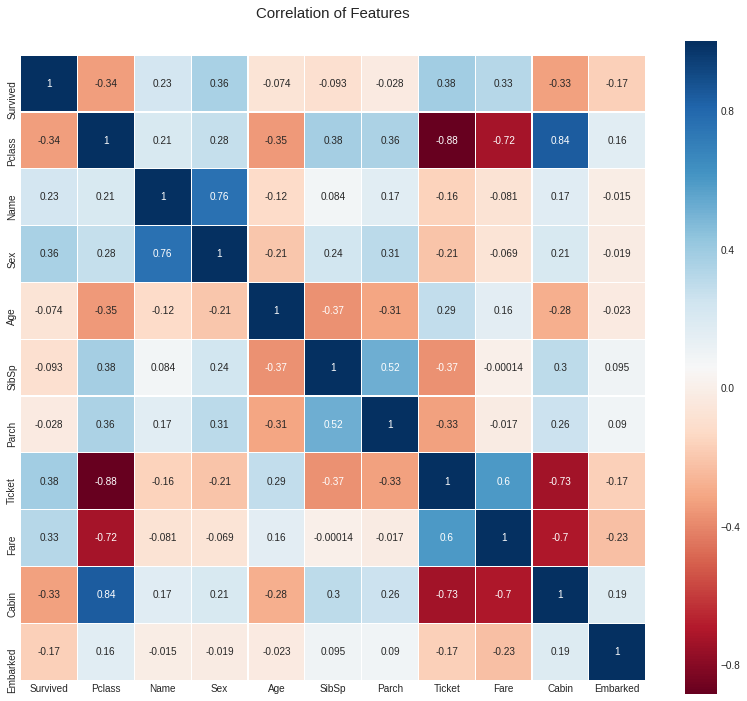

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
train = df.copy()

In [ ]:
from sklearn.model_selection import KFold

# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
kf = KFold(ntrain, random_state=SEED)
NFolds = 5
kf.get_n_splits(NFolds)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [ ]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = y_train.ravel()
x_train = x_train.ravel()
x_test = test.ravel()

AttributeError: ignored

In [ ]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

In [ ]:
rf_features = [0.03897754, 0.26020243, 0.29622819, 0.07664037, 0.03550016, 0.02977056, 0.08813598, 0.0689509,  0.08008833, 0.02550553]
et_features = [0.1020756,  0.14078547, 0.36185109, 0.05150881, 0.03407633, 0.03422197,  0.07895228, 0.08131172, 0.08233612, 0.03288062]
ada_features = [0.,    0.168, 0.026, 0.118, 0.094, 0.166, 0.192, 0.136, 0.092, 0.008]
gb_features = [0.00133196, 0.07796875, 0.37651451, 0.15526469, 0.04784731, 0.02053356, 0.15186205, 0.08926399, 0.0460524,  0.03336079]

In [ ]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [ ]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(10)

In [ ]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()